#  TP  MCS  1 à 3  : Reconnaissance de commandes audio par DTW

**Nom du Groupe :** L'aigle royaux

**Noms :** ARSAC, LOISY, RAYMONDAUD

**Prénoms :** Jonathan, Léo, Quentin

**Parcours :** IGAI

Ces trois séances de TP (2 séances encadrées et une non encadrée) vont vous permettre de tester l'algorithme de programmation dynamique vu en
TD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).



Ces séances se décomposent en 3 parties : 
- Partie I : DTW et application du TD
- Partie II : Système de reconnaissance audio de mots de commande
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Pour les **parties II et III**, vous testerez le système de reconnaissance audio sur deux corpus de voix qui serviront respectivement de base d'apprentissage (références) et de base de test (sons à reconnaître) que vous choisirez. La liste des 13 commandes au drone sont : *Atterrissage, Décollage, Avance, Tourne droite, Recule, Tourne gauche, Droite, Fais un flip, Gauche, Arrête toi, plus haut, plus bas et Etat d'urgence.*



Pour cela, vous devez par groupe de **3 étudiants** (effectif **OBLIGATOIRE**):
1. **Proposer une étude** que vous détaillerez sur un rapport
[par exemple, *influence voix masculines VS voix féminines, confronter vos propres voix à la base de données, tester l'impact de différents bruits de fond sur la reconnaissance...*];
2. Créer, en fonction de l'objectif de votre étude, vos propres base d'apprentissage et base de test à partir du corpus proposé et des voix et bruits que vous aurez enregistrés [*paramètres audio : 16 KHz, mono, 16 bits, format *.wav**];
3. Tester la DTW et une méthode de classification avec prétraitement par ACP;
4. Evaluer les résultats; 
5. Rédiger un rapport en pdf présentant l'étude, les résultats par les 2 méthodes et vos commentaires et conclusions sur votre étude (Longueur max. : 5 pages).

In [0]:
import matplotlib.pyplot as plt
from numpy import array, zeros, full, argmin, inf, ndim
import scipy
import sklearn
import math

# Partie I : Implémentation de l'algorithme de programmation dynamique 


1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 

2. Afin d'adapter facilement le calcul des coûts suivant la nature des données (et donc des distances utilisées), écrivez une fonction pour chaque distance (euclidienne, lettres, sons) qui apparaîtra en paramètre de la fonction DTW.

In [0]:
import numpy as np

def distanceEuclidienne(a, b):
  return abs(b-a)

def distanceLettre(a, b):
  return 0 if a==b else 1

def distanceSons(a, b):
  d={
      'X' : {'X':0, 'C':1, 'U':1, 'UX':1, 'V':2},
      'C' : {'X':1, 'C':0, 'U':1, 'UX':1, 'V':2},
      'U' : {'X':1, 'C':1, 'U':0, 'UX':1, 'V':1},
      'UX' : {'X':1, 'C':1, 'U':1, 'UX':0, 'V':2},
      'V' : {'X':2, 'C':2, 'U':1, 'UX':2, 'V':0}      
  }
  return d[a][b]

def DTW(seq2, seq1, d, w0=1, w1=1, w2=1, bounds=0):
  I=len(seq1)
  J=len(seq2)
  res = np.zeros((I+1, J+1))
  res[0][0] = 0
  
  for j in range(1,J+1):
    res[0][j] = np.inf
  for i in range(1,I+1):
    res[i][0] = np.inf
    if(bounds != 0):
      for j in range(i-bounds, i+bounds+1):
        if(j>0 and j<J+1):
          dist = d(seq1[i-1], seq2[j-1])
          if(j<i+bounds):
            left = res[i-1][j]+w0*dist
          else :
            left = np.inf
          diag = res[i-1][j-1]+w1*dist
          if(j>i-bounds):
            top = res[i][j-1]+w2*dist
          else :
            top = np.inf
          res[i][j] = min( left, diag, top )
    else: 
      for j in range(1, J+1):
        dist = d(seq1[i-1], seq2[j-1])
        res[i][j] = min( res[i-1][j]+w0*dist, res[i-1][j-1]+w1*dist, res[i][j-1]+w2*dist )
  cost = res[I][J]/(I+J)
  return res,cost

### Application aux exercices 

1. Testez vos programmes sur les exercices vus en TD. 

2. Modifiez les contraintes locales c'est-à-dire les pondérations suivant les directions. 

3. Ajoutez la prise en compte de contraintes globales c'est-à-dire le non calcul lorsque les cases sont trop éloignées de la diagonale (cf exercice TD séquence ADN). A partir de quelle position les contraintes globales ne changent pas les résultats ?

In [4]:
######### Question 1 #########
print("TD exo seq numérique :")
seq1 = np.array([-2, 10, -10, 15, -13, 20, -5, 14, 2])
seq2 = np.array([3, -13, 14, -7, 9, -2])
print(DTW(seq1, seq2, distanceEuclidienne))

print("TD exo ADN :")
seq1 = np.array(['A','T','G','G','T','A','C','G','T','C'])
seq2 = np.array(['A','A','G','T','A','G','G','C'])
print(DTW(seq1, seq2, distanceLettre))

print("TD exo signal audio :")
seq1 = np.array(['X','X','V','U','X','C','X'])
seq2 = np.array(['X','V','V','C','X'])
print(DTW(seq1, seq2, distanceSons,1,2,1))
seq2 = np.array(['UX','V','V'])
print(DTW(seq1, seq2, distanceSons,1,2,1))
seq2 = np.array(['X','V','V'])
print(DTW(seq1, seq2, distanceSons,1,2,1))

TD exo seq numérique :
(array([[  0.,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf],
       [ inf,   5.,  12.,  25.,  37.,  53.,  70.,  78.,  89.,  90.],
       [ inf,  16.,  28.,  15.,  43.,  37.,  70.,  78., 105., 104.],
       [ inf,  32.,  20.,  39.,  16.,  43.,  43.,  62.,  62.,  74.],
       [ inf,  37.,  37.,  23.,  38.,  22.,  49.,  45.,  66.,  71.],
       [ inf,  48.,  38.,  42.,  29.,  44.,  33.,  47.,  50.,  57.],
       [ inf,  48.,  50.,  46.,  46.,  40.,  55.,  36.,  52.,  54.]]), 3.6)
TD exo ADN :
(array([[ 0., inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf,  0.,  1.,  2.,  3.,  4.,  4.,  5.,  6.,  7.,  8.],
       [inf,  0.,  1.,  2.,  3.,  4.,  4.,  5.,  6.,  7.,  8.],
       [inf,  1.,  1.,  1.,  1.,  2.,  3.,  4.,  4.,  5.,  6.],
       [inf,  2.,  1.,  2.,  2.,  1.,  2.,  3.,  4.,  4.,  5.],
       [inf,  2.,  2.,  2.,  3.,  2.,  1.,  2.,  3.,  4.,  5.],
       [inf,  3.,  3.,  2.,  2.,  3.,  2.,  2.,  2.,  3.,  4.],
       [inf,  4.,  4.,  

# Partie II :  Système de reconnaissance audio de mots de commande

Sur l'espace partagé, vous trouverez des enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05).

Vous pouvez diviser ainsi l'ensemble des données en base d'apprentissage qui serviront de références et base de test pour évaluer la reconnaissance par programmation dynamique.

In [0]:
import librosa
import os
from google.colab import files

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond à la dimension du vecteur représentatif : ici 12.

**Chargement fichiers audio et Calcul des MFCC**:

In [6]:

#Audio(file,rate)

# Téléchargement des fichiers audio sur le Colab
#files.upload()
fileNames = os.listdir()

mfccList = {}
mfccTestList = {}


# ATTENTION  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx ATTENTION xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

###### LA BASE D'APPRENTISSAGE DOIT ETRE COMPOSEE DE FICHIERS DE NOM COMMENCANT PAR M01_
###### LA BASE DE TEST DOIT ETRE COMPOSEE DE FICHIERS DE NOM COMMENCANT PAR M02_

###### LE RESTE DU NOM DE FICHIER DOIT ÊTRE STRICTEMENT IDENTIQUE !

#### Il est possible de modifier dans les deux conditions suivantes les préfixes des noms de fichier de test et d'apprentissage
#### MAIS ILS DOIVENT IMPERATIVEMENT ÊTRE DE TAILLE 4 ( string de taille 4) 
#### Le reste du nom du fichier est utilisé pour calcule le taux de reconnaissance sur les deux méthodes

# FIN ATTENTION  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx FIN ATTENTION xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

for e in fileNames:

  if e[-4:] == '.wav':

    if e[:4] == 'M01_':
      y1, sr1 = librosa.load(e) # Chargement de tous les fichiers wav du repertoire commencant par 'str'  
      print ("BA : Ajout Fichier : " + e + " base d'apprentissage ")
      mfccList[e] = librosa.feature.mfcc(y=y1, sr=sr1, hop_length=1024, htk=True, n_mfcc=12) # Calcul de la MFCC pour chaque fichier wav du rep courant et ajout dans la base d'apprentissage 
      mfccList[e] = np.transpose(mfccList[e])
    elif e[:4] == 'M02_':
      y1, sr1 = librosa.load(e) # Chargement de tous les fichiers wav du repertoire courant commencant par 'str'
      print ("BT : Ajout Fichier : " + e + " Base de test")
      mfccTestList[e] = librosa.feature.mfcc(y=y1, sr=sr1, hop_length=1024, htk=True, n_mfcc=12) #Calcul et ajout de la MFCC dans la base de test
      mfccTestList[e] = np.transpose(mfccTestList[e])

# CENSE AMELIORER RECONNAISSANCE QUANT BRUIT #
for kT,mfccToRecognize in mfccTestList.items():
    
        (nframes, ncoeff) = mfccToRecognize.shape
        n = np.arange(ncoeff)
        lift = 1 + (30 / 2) * np.sin(np.pi * n / 30)
        mfccToRecognize *= lift  
        mfccToRecognize -= (np.mean(mfccToRecognize, axis=0) + 1e-8)

# CENSE AMELIORER RECONNAISSANCE QUANT BRUIT #
for kT,mfccToRecognize in mfccList.items():
    
        (nframes, ncoeff) = mfccToRecognize.shape
        n = np.arange(ncoeff)
        lift = 1 + (14 / 2) * np.sin(np.pi * n / 14)
        mfccToRecognize *= lift  
        mfccToRecognize -= (np.mean(mfccToRecognize, axis=0) + 1e-8)


BT : Ajout Fichier : M02_decollage.wav Base de test
BT : Ajout Fichier : M02_tournedroite.wav Base de test
BT : Ajout Fichier : M02_plusbas.wav Base de test
BA : Ajout Fichier : M01_gauche.wav base d'apprentissage 
BA : Ajout Fichier : M01_avance.wav base d'apprentissage 
BT : Ajout Fichier : M02_arretetoi.wav Base de test
BA : Ajout Fichier : M01_plushaut.wav base d'apprentissage 
BA : Ajout Fichier : M01_atterrissage.wav base d'apprentissage 
BA : Ajout Fichier : M01_faisunflip.wav base d'apprentissage 
BA : Ajout Fichier : M01_droite.wav base d'apprentissage 
BA : Ajout Fichier : M01_arretetoi.wav base d'apprentissage 
BT : Ajout Fichier : M02_atterrissage.wav Base de test
BT : Ajout Fichier : M02_recule.wav Base de test
BA : Ajout Fichier : M01_tournedroite.wav base d'apprentissage 
BT : Ajout Fichier : M02_faisunflip.wav Base de test
BT : Ajout Fichier : M02_plushaut.wav Base de test
BA : Ajout Fichier : M01_tournegauche.wav base d'apprentissage 
BT : Ajout Fichier : M02_etatdurge

In [7]:
# AFFICHAGE DE LA LISTE DES MFCC BASE APPRENTISSAGE
def printDic( dic , id):
  for k,elem in dic.items() :
    print("\n\n BASE "+id+" : Nb Coeff MFCC x Nb Fenetres :",elem.shape,"\n")
    for i in range(elem.shape[0]):
      for j in range(elem.shape[1]):
        print(elem[i][j], end='\t\t'),
      print("")


printDic(mfccList,"APPRENTISSAGE");
printDic(mfccTestList,"TEST");




 BASE APPRENTISSAGE : Nb Coeff MFCC x Nb Fenetres : (21, 12) 

-59.42062658702895		-4.162636449095501		102.98416134284764		-56.85580222489352		50.132557797306106		90.77907629057746		142.9918042064343		32.1497701613191		72.122697781082		68.59347772060741		1.1171020062177472		36.344223365126595		
-64.76059444695048		-26.093178373693306		76.7581394634316		-70.45969183986142		19.931168591138203		51.19499288064044		72.88925273743487		-55.02313818045867		25.937873251451023		13.96943783969283		-69.65624026859251		-8.845445937390636		
-62.62260734775535		-25.823915551643083		84.16888237898198		-67.19116034407296		-9.737944760220557		49.30034523329522		94.88228544938949		-46.088470070129475		43.12366533742641		77.78629606490345		5.096140793188621		36.10111334582578		
-68.80786575579597		-24.47788544443705		90.49000055883766		-70.80613302206689		-25.463212951432354		5.711329581166453		85.4161248129337		-34.705354817008825		81.23094455927217		73.92481273398232		7.100521341385729		41.43809799536

**Application de la DTW**

1. Réaliser une étude que vous détaillerez sur un rapport (par exemple, *influence voix masculines VS voix féminines, confronter votre propre voix à la base de données, tester l'impact de différents bruits de fond sur la reconnaissance...*) et créer votre propre base d'apprentissage et votre base de test à partir du corpus et des voix et bruits que vous aurez enregistrés. 

2. Appliquer la DTW sur vos corpus.

**Paramètres pour enregistrements audio de vos voix perso:**

16 KHz, mono, 16 bits, format *.wav*

In [0]:
# Première ligne de MFCC = puissance => s'en servir pour reconnaitre silence ou pas au début
# Construire une matrice Verité en Y et ce qu'on a trouvé en X 
# On ajoute  +1 a chaque fois qu'on test un enregistrement qui a un score qui match le plus avec un autre score correspondant a un enregistrement
# match = Score min entre {E1 & ER1; E1 & ER2; E & ER2}


listCostList = {}
costList = {}
sumCost = 0
for kT,mfccToRecognize in mfccTestList.items():
  for k,mfcc in mfccList.items() :
    minLength = min( mfccToRecognize.shape[1] , mfcc.shape[1] ) # Inutile mais je garde :D
    sumCost = 0
    for j in range(minLength):
      res , cost = DTW(mfcc[:,j],mfccToRecognize[:,j],distanceEuclidienne)
      sumCost += cost
    costList[k] = sumCost
  listCostList[kT] = costList
  costList={}

#for key, i in listCostList.items():
#  print(key + ' : ', end = '')
#  print(i.items())

**Evaluation de la reconnaissance**

1. Calculer la matrice de confusion du système (en ligne les références et en colonne les sorties du système). 
Vous pourrez utiliser la fonction *confusion_matrix* de la librairie *sklearn*.


2. Calculer le score de reconnaissance : nombre de fichiers bien reconnus sur nombre de fichiers testés. 

*Vérifications :*
-  si vous prenez comme fichier de référence et de test M01, vous devez obtenir aucune erreur.
-  si vous prenez comme fichier de reférénce M01 et fichier de test M02, vous devez obtenir deux erreurs.

In [9]:
total = 0
succes = 0
for key, i in listCostList.items():
  total +=1
  val = min(i, key=i.get)
  print ( "Pour " + key + " on reconnait " + val )
  if ( key[4:] == val[4:]):
    succes +=1

print (" Score reco = " + str(succes/total) )

Pour M02_decollage.wav on reconnait M01_recule.wav
Pour M02_tournedroite.wav on reconnait M01_tournedroite.wav
Pour M02_plusbas.wav on reconnait M01_decollage.wav
Pour M02_arretetoi.wav on reconnait M01_arretetoi.wav
Pour M02_atterrissage.wav on reconnait M01_recule.wav
Pour M02_recule.wav on reconnait M01_recule.wav
Pour M02_faisunflip.wav on reconnait M01_faisunflip.wav
Pour M02_plushaut.wav on reconnait M01_plushaut.wav
Pour M02_etatdurgence.wav on reconnait M01_recule.wav
Pour M02_tournegauche.wav on reconnait M01_recule.wav
Pour M02_droite.wav on reconnait M01_tournedroite.wav
Pour M02_avance.wav on reconnait M01_plushaut.wav
Pour M02_gauche.wav on reconnait M01_decollage.wav
 Score reco = 0.38461538461538464


## Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les k-ppv via la librairie python *scikit-learn*.




In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

### Prétraitement par ACP

Pour tester une méthode de classification, il faut d'abord réduire la dimension des MFCC

1. A partir de tous les enregistrements de la base d'apprentissage, réalisez une Analyse en composantes principales (A.C.P) en utilisant la fonction *PCA* de la librairie *scikit-learn* puis projetez les données de test dans cette nouvelle base. 

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère $P$.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




[[  71.44791238   23.75827206    4.5477657 ]
 [ 166.41504651  -94.16041825   52.48472453]
 [ -43.84946319   72.72711271  -32.96733009]
 [ -61.23157534  -60.98696263  -72.4470247 ]
 [ -69.23388848 -171.52091783  113.88079443]
 [ -72.60749072  -86.0142787  -103.16200289]
 [   7.63135471 -101.57227996  -58.61271948]
 [  84.04294128   55.08535281  -55.80665218]
 [  31.9449085    55.25730468   41.20716872]
 [ 217.68258677   84.41721595    3.01560413]
 [ -18.72595544   46.72657398   30.44279821]
 [-182.21126237   91.68398383   12.70568575]
 [-131.30511461   84.59904134   64.71118788]]
[[ 8.46838814e+01  2.47566716e+02  1.10291551e+02]
 [ 1.18899917e+02  2.25623398e+02 -1.73921876e+01]
 [ 1.47120125e+02  2.39801684e+02  1.89035314e+01]
 [ 1.63561849e+02  4.81957245e+01  1.06793273e+02]
 [ 1.36126851e+02  2.95639550e+01  8.18359114e+01]
 [ 1.33312256e+02  2.56179932e+01  1.24993234e+02]
 [ 6.14311080e+01 -3.14271641e-01  1.42864029e+02]
 [ 1.27362247e+02  2.03040840e+02 -1.08366047e+01]
 [ 1.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


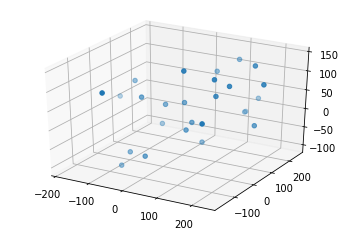

In [11]:
def printMatrix ( mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      print(mat[i][j], end='\t\t'),
    print("")
  print("\n\n")

def mfccTToAcpDataformat(mfccList,disp = False):
  ACPMatrix= []                                                   # Base
  values = []
  countEnr = 0;
  for k,mfcc in mfccList.items() :                                # Pour chaque mfccTransposée 
    ACPMatrix.append([])                                          # Je créé un vecteur de taille 12
    values.append([])
    if disp:
      print(" ACP data vector[12] of sample " + k + " : \t ", end=' ')
    for i in range(mfcc.shape[1]) :                               # Pour chaque colonne i de la mfccT
      if disp:
        print( np.mean(np.array(mfcc[0,i])),end='  \t=>\t ['+str(i)+']  \t \t \t')      
      ACPMatrix[countEnr].append(np.mean(np.array(mfcc[0,i])))    # Je calcule sa moyenne qui deviendra l'element i dans le vecteur ACP
    values[countEnr].append(k)
    countEnr +=1
    if disp:
      print("")
  if disp:
      print("\n\n")
  return np.array(ACPMatrix),np.array(values)

# Ligne individus / Colonnes caractèristiques ( moyenne de chaque ligne de la MFCC transposée )
acpTraining,valuesTraining = mfccTToAcpDataformat(mfccList,False)
acpTest,valuesTest = mfccTToAcpDataformat(mfccTestList,False)
#print(acpTraining)
mu = acpTraining.mean(0)
C = np.cov(acpTraining - mu, rowvar=False)
d, u = np.linalg.eigh(C)
U = u.T[::-1]
Z = np.dot(acpTraining - mu, U[:3].T)
T = np.dot(acpTest - mu, U[:3].T)
print(Z)
print(T)
globalRes =  np.concatenate((Z,T),axis = 0 )
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(globalRes[:,0], globalRes[:,1] , globalRes[:,2] , zdir='z', s=20, c=None, depthshade=True)
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(Z, valuesTraining)
res = neigh.predict(T)
score = 0

print (" Resultats ACP : \n\n")
for i in range(valuesTest.size):
  if ( valuesTest[i][0][4:] == res[i][4:]):
    score+=1
  print (valuesTest[i][0][4:] + "    \t  match with \t \t" + res[i][4:] )
print("\n\n--ACP WINRATE = "+ str(score/valuesTest.size) +"--\n\n")



### Classification par $k$ plus proches voisins

En intelligence artificielle, la méthode des $k$ plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée $x$, la méthode des $k$ plus proches voisins consiste à prendre
en compte (de façon identique) les $k$ échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée $x$, selon une distance à définir. L'algorithme 1 associé et un exemple sont donnés par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par $k$-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si $k = 3$ (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si $k = 5$ (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.

5. Rédigez un rapport sur votre étude, vos résultats et vos commentaires/conclusions.


